In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import *

/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Could not load libcorrections.


In [2]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

#pede_file = "/sf/alvra/data/res/p16581/pedestal_20180307_2303_res.h5"
pede_file = f"/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190702_0823.JF02T09V02.res.h5"
# pede_file = "/sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190329_1408.JF02T09V01.res.h5"
#pede_file = f"/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190701_1630.JF02T09V02.res.h5"
#pede_file = "/sf/alvra/data/p17803/res/JF_pedestals/pedestal_20190124_2035.JF02T09V01.res.h5"
gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    original_mask = file["pixel_mask"][:]

print("Dimensions of G: ", G.shape)
print("Dimensions of P: ", P.shape)
print("Dimensions of mask: ", original_mask.shape)

# G_test = np.stack(ju.apply_geometry(i, "JF02T09V02") for i in G)
# P_test = np.stack(ju.apply_geometry(i, "JF02T09V02") for i in P)
# original_mask_test = ju.apply_geometry(original_mask, "JF02T09V02")

#print (G_test.shape)
#print (P_test.shape)
#print (original_mask_test.shape)

Dimensions of G:  (4, 4608, 1024)
Dimensions of P:  (4, 4608, 1024)
Dimensions of mask:  (4608, 1024)


In [3]:
pgroup = "p17983"
DIR = f"/sf/alvra/data/{pgroup}/raw/test003/"
#DIR = f"/sf/alvra/data/{pgroup}/raw/"

DIR_json = f"/sf/alvra/data/p17983/res/scan_info/"

!ls -lah -t $DIR

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.3G
drwxrws---. 7 root  p17983 4.0K Jul  2 10:11 ..
drwxrwsr-x. 2 17983 p17983 4.0K Jul  1 22:43 .
-rw-r--r--. 1 17983 p17983 5.2K Jul  1 22:43 run_000003.BSREAD.h5
-rw-r--r--. 1 root  p17983 4.1K Jul  1 17:08 run_000003.BSREAD.h5.err
-rw-r--r--. 1 17983 p17983 901M Jul  1 17:07 run_000003.JF02T09V02.h5
-rw-r--r--. 1 17983 p17983 401M Jul  1 17:07 run_000003.JF06T04V01.h5
ra-c-004.psi.ch
There are 4 files in the folder /sf/alvra/data/p17983/raw/test003/


<HDF5 file "run_000003.JF02T09V02.h5" (mode r)>
(100, 4608, 1024)
(4608, 1024)


<IPython.core.display.Javascript object>


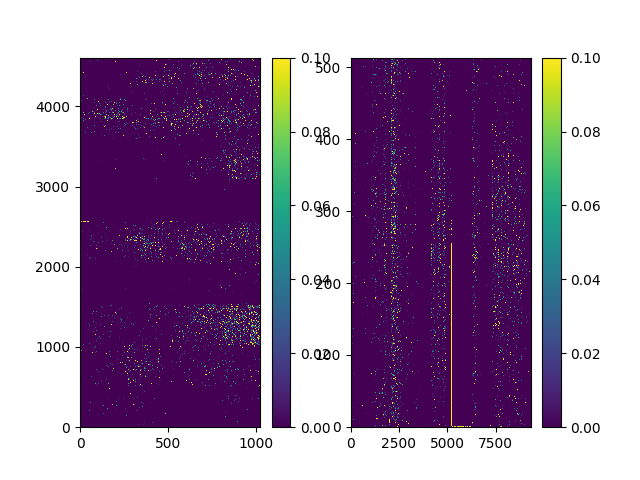

In [10]:
# First we load the first images of a file to check if everything is fine with the pedestal & gain files (check highgain True or False)
# We can see also how the ROIs look like (will be useful later)

fileName = "run_000003.JF02T09V02.h5"
#fileName = "CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0015.JF02T09V01.h5"

jf_file = h5py.File(DIR + fileName)

print(jf_file)

images = jf_file["data/" + channel_JF_images]
pulse_ids = jf_file["data/" + channel_JF_pulse_ids]
try:
    module_maps = jf_file[f"/data/{detector_name}/module_map"]
except:
    module_maps = None

print(images.shape)

nframes = 10
#nframes = images.shape(0)

total = 0

mask = original_mask.copy()

for i in range(nframes):
    image = images[i, :]
    module_map = module_maps[i, :]
    if module_map is not None and -1 in module_map:
        # fill disabled modules with zeros
        image_ext = np.zeros((512 * len(module_map), 1024), dtype=image.dtype)
        for i, m in enumerate(module_map):
            if m == -1:
                mask[512 * i : 512 * (i + 1), :] = 1
            else:
                image_ext[512 * i : 512 * (i + 1), :] = image[512 * m : 512 * (m + 1), :]
                mask[512 * i : 512 * (i + 1), :] = original_mask[512 * i : 512 * (i + 1), :]
                
        image = image_ext      

    total += ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=False)#[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]

total /= nframes
total_corr = ju.apply_geometry(total, detector_name)

print (total.shape)

#roi = [[225, 325], [6950, 7075]]
#roi = [[225, 325], [7900, 8450]]
#roi = [[0, total_corr.shape[0]], [0, total_corr.shape[1]]]

plt.figure()
plt.subplot(121)
plt.imshow(total, origin="lower", aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
plt.subplot(122)
plt.imshow(total_corr, origin="lower", aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

# Set the ROIs (roi1 & roi2 in pixels) in the next cell

In [46]:
# Ka emission 
roi1 = [[250, 300], [8000, 9050]] # change these numbers, here they are for both crystals1 (up & down) overlapped
#roi1 = [[7030, 7130], [220, 290]]
#roi1 = [[100, 200], [8000, 9000]]

# Kb emission 
roi2 = [[100, 400], [6700, 7000]] # change these numbers, here they are for both crystals2 (up & down) overlapped

##################################################################

P_r_roi2 = P[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
G_r_roi2 = G[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
mask_r_roi2 = mask[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

# The next cell is to analyse a single file or a series of identical ones to be summed up

In [47]:
#files = ["Kalpha_Fe_foil_8keV_0.1trans_3"]          # you need to change only this name
#files = ["CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0019","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0020","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0022","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0023"]

files = ["run_000004"]
######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
energy_eV = 0
        
for f in files:
    
    JF_single_file = DIR + f + ".JF02T09V02.h5"
    BS_single_file = DIR + f + ".BSREAD.h5"
    print("Processing file %s" % (JF_single_file))
    
    (image_ON, image_OFF, pulseIDs) = load_JF_data_OnOff_pulseID(str(JF_single_file), 50, 25)
    
    nframes_ON = np.ma.size(image_ON,0)
    nframes_OFF = np.ma.size(image_OFF,0)
    print (nframes_ON, nframes_OFF)
#    threshold = 2
#    threshold_low = 3 
#    threshold_high = 7
    #photon_range = (6, 7)
    
    for j in range(nframes_ON):
        
        image_ON_2D = image_ON[j,:,:]
        image_ON_2D = ju.apply_gain_pede(image_ON_2D, G=G, P=P, pixel_mask=mask, highgain=False)
        image_ON_2D_corr = ju.apply_geometry(image_ON_2D, detector_name)
        image_ON_2D_roi1 = image_ON_2D_corr[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_ON_2D_roi2 = image_ON_2D_corr[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
#        image_ON_2D_roi1[image_ON_2D_roi1 < threshold_low] = 0
#        image_ON_2D_roi1[image_ON_2D_roi1 > threshold_high] = 0
#        image_ON_2D_roi2[image_ON_2D_roi2 < threshold_low] = 0
#        image_ON_2D_roi2[image_ON_2D_roi2 > threshold_high] = 0

#        image_ON_2D_roi1 = convert_to_photon_num_range(image_ON_2D_roi1)
#        image_ON_2D_roi2 = convert_to_photon_num_range(image_ON_2D_roi2)

#        if Izero_pump[j]>(meanI0pump-1.2*sigmaI0pump) and Izero_pump[j]<(meanI0pump+1.2*sigmaI0pump):
        spectrum_ON_roi1 += image_ON_2D_roi1.sum(axis=0)#/Izero_pump[j]
        spectrum_ON_roi2 += image_ON_2D_roi2.sum(axis=0)#/Izero_pump[j]
    
        image_OFF_2D = image_OFF[j,:,:]
        image_OFF_2D = ju.apply_gain_pede(image_OFF_2D, G=G, P=P, pixel_mask=mask, highgain=False)
        image_OFF_2D_corr = ju.apply_geometry(image_OFF_2D, detector_name)
        image_OFF_2D_roi1 = image_OFF_2D_corr[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_OFF_2D_roi2 = image_OFF_2D_corr[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
#        image_OFF_2D_roi1[image_OFF_2D_roi1 < threshold_low] = 0
#        image_OFF_2D_roi1[image_OFF_2D_roi1 > threshold_high] = 0
#        image_OFF_2D_roi2[image_OFF_2D_roi2 < threshold_low] = 0
#        image_OFF_2D_roi2[image_OFF_2D_roi2 > threshold_high] = 0

#        image_OFF_2D_roi1 = convert_to_photon_num_range(image_OFF_2D_roi1)
#        image_OFF_2D_roi2 = convert_to_photon_num_range(image_OFF_2D_roi2)

#        if Izero_pump[j]>(meanI0pump-1.2*sigmaI0pump) and Izero_pump[j]<(meanI0pump+1.2*sigmaI0pump):
        spectrum_OFF_roi1 += image_OFF_2D_roi1.sum(axis=0)#/Izero_pump[j]
        spectrum_OFF_roi2 += image_OFF_2D_roi2.sum(axis=0)#/Izero_pump[j]
    
        
print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",np.size(files),"file(s)")


Processing file /sf/alvra/data/p17983/raw/testBS/run_000004.JF02T09V02.h5
500 500
Job done! It took 109.82 seconds to process 1 file(s)


In [4]:
roi1 = (8000, 9050, 250, 300)
roi2 = (6700, 7000, 100, 400)

files = ["run_000003"]
######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
energy_eV = 0
        
for f in files:
    
    JF_single_file = DIR + f + ".JF02T09V02.h5"
    BS_single_file = DIR + f + ".BSREAD.h5"
    print("Processing file %s" % (JF_single_file))

#    threshold = 2
#    threshold_low = 3 
#    threshold_high = 7
#    photon_range = (6, 7)
    
    images_ON_roi1, images_ON_roi2, images_OFF_roi1, images_OFF_roi2, pids = \
    load_crop_JF_data_on_off(JF_single_file, roi1, roi2, 50, 25, max_num_frames=50)
    
#    Izero_pump, Izero_unpump, energy_eV, pulseIDs = \
#    load_FEL_pp_pulseID(BS_single_file, channel_energy, 50, 25, 50)  
    
    
#   images_ON_roi1[images_ON_roi1 < threshold_low] = 0
#   images_ON_roi1[images_ON_roi1 > threshold_high] = 0
#   images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

#   images_ON_roi2[images_ON_roi2 < threshold_low] = 0
#   images_ON_roi2[images_ON_roi2 > threshold_high] = 0
#   images_ON_roi2 = convert_to_photon_num_range(images_ON_roi2)


#   images_OFF_roi1[images_OFF_roi1 < threshold_low] = 0
#   images_OFF_roi1[images_OFF_roi1 > threshold_high] = 0
#   images_OFF_roi1 = convert_to_photon_num_range(images_OFF_roi1)


#   images_OFF_roi2[images_OFF_roi2 < threshold_low] = 0
#   images_OFF_roi2[images_OFF_roi2 > threshold_high] = 0
#   images_OFF_roi2 = convert_to_photon_num_range(images_OFF_roi2)

    spectrum_ON_roi1 = images_ON_roi1.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_OFF_roi1.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2 = images_ON_roi2.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_OFF_roi2.sum(axis = 1).sum(axis = 0)
    
print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",np.size(files),"file(s)")


Processing file /sf/alvra/data/p17983/raw/test003/run_000003.JF02T09V02.h5
Job done! It took 0.78 seconds to process 1 file(s)


In [13]:
f=h5py.File(BS_single_file); channel_BS_pulse_ids

print(list(f.keys()))
"data" in f


['general']


False

In [8]:
roi1 = [[250, 300], [8000, 9050]]

bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[1][0], roi1[1][1])

spectra_on_rebin1 = bin_sum(spectra_on, bin_)
spectra_off_rebin1 = bin_sum(spectra_off, bin_)
x_axis_rebin1 = bin_mean(x_axis, bin_)

spectra_on_err1=np.sqrt(spectra_on_rebin1)
spectra_off_err1=np.sqrt(spectra_off_rebin1)

plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1,spectra_on_rebin1, label="ON",marker='.')
plt.plot(x_axis_rebin1,spectra_off_rebin1, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
#plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
#plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

AttributeError: 'int' object has no attribute 'copy'